In [17]:
import numpy as np
from numpy import random
import pandas as pd
import joblib
import pickle
import matplotlib.pyplot as plt
from matplotlib import pyplot
import math, decimal
from math import exp
import seaborn as sns
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score, f1_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from xgboost import XGBClassifier,XGBRFClassifier
from collections import Counter
seedRF =50


In [ ]:
### Data manipulation and helper methods  ###
def meanStd(dataset):
    '''
    dataset_minmax(dataset)
    return a list like {min:#,max:#}
    # Find the min and std values for each column
    '''
    col = dataset.shape[1]
    meanVal, stdVal = 0,0
    stats = list()
    for i in range(col):
        val = dataset.iloc[:, i]
        meanVal = np.mean(val)
        stdVal = np.std(val)
        stats.append([meanVal,stdVal])
    return stats

def standardize_data(dataset, mean_std):
    '''
    standardize_data(dataset, mean_std)
    @mean_std: @arguent: list of min/max valuer per column {min:#,max:#}
    # Rescale dataset columns to the range 0-1
    '''
    col = dataset.shape[1]
    row = dataset.shape[0]
    for i in range(1,col):
        for n in range(row):
            dataset.iloc[n,i] -= mean_std[i][0]
            dataset.iloc[n,i] /= mean_std[i][1]
    return dataset


In [4]:
                ## uncoment to apply
####    importing original datasets and filling NaN values 
# train = pd.read_csv("train.csv", index_col = None)
# y = train[['LABELS']]
# ## x = pd.read_csv("x_standardized.csv", index_col = None) # to import sandardized dataset
# x = train.drop('LABELS', axis=1)
# ## Correction of empty values with means by columns
# xMean = x.mean()
# x = x.fillna(xMean)
# test_nolabels = pd.read_csv("test_nolabels.csv", index_col = None)
# test_nolabels = test_nolabels.fillna(xMean)

###     Replacing columns of elevation and slope by yearly means
# toposElevation = {"topo_elevation_jan",'topo_elevation_feb','topo_elevation_mar','topo_elevation_apr','topo_elevation_may','topo_elevation_jun','topo_elevation_jul','topo_elevation_aug','topo_elevation_sep','topo_elevation_oct','topo_elevation_nov','topo_elevation_dec'}
# topoSlope = {'topo_slope_jan','topo_slope_feb','topo_slope_mar','topo_slope_apr','topo_slope_may','topo_slope_aug','topo_slope_jun','topo_slope_jul','topo_slope_sep','topo_slope_oct','topo_slope_nov','topo_slope_dec'}
# topoElevationDF = x[toposElevation]
# topoElevationMean = topoElevationDF.mean(axis=1)
# x = x.drop(toposElevation,axis=1)
# x['topoElevationMean'] = topoElevationMean
# topoSlopeDF = x[topoSlope]
# topoSlopeMean = topoSlopeDF.mean(axis=1)
# x = x.drop(topoSlope, axis=1)
# x['topoSlope'] = topoSlopeMean

In [16]:
     ## uncoment to apply
# #preprocessing No_label datase:
# test_nolabels = test_nolabels.fillna(xMean)
# test_nolabels = test_nolabels.drop(toposElevation, axis=1)
# test_nolabels = test_nolabels.drop(topoSlope, axis=1)
# test_nolabels['topoElevationMean'] = topoElevationMean
# test_nolabels['topoSlope'] = topoSlopeMean
# ## standardizing test_nolabels
# mean_std_x_noLabel = meanStd(test_nolabels)
# test_nolabels = standardize_data(test_nolabels, mean_std_x_noLabel)

In [19]:
#### working with standardized dataSets
train = pd.read_csv("train.csv", index_col = None)
y = train[['LABELS']]
x = pd.read_csv("x_standardized.csv", index_col = None)
test_nolabels = pd.read_csv("nonLabeled_standardized.csv", index_col = None)

In [20]:
print(np.shape(x))
print(np.shape(test_nolabels))


(62000, 196)
(1200, 196)


In [82]:
x_train, x_validation, y_train, y_validation = train_test_split( x,y, test_size=0.2)
y_train = (np.array(y_train).astype('int')).ravel()
y_validation = (np.array(y_validation).astype('int')).ravel()

In [ ]:
## Data shape exploration
print("",np.shape(x_train),"  :",np.shape(x_validation) )
print("Label balance on Training set: ", "\n", y_train['LABELS'].value_counts())
print("Label balance on Validation set: ", "\n", y_validation['LABELS'].value_counts())
print("Label balance on Validation set: ", "\n", y_validation['LABELS'].value_counts())


In [7]:
### Some helpers function
# To adapt the prediction to Kaggel format of submission 
def formating_prediction(predictions): 
        '''
        Return the prediction in the Kaggle format submition
        @hypotesis : column of classes 
        '''
        y_hat = pd.DataFrame({'S.No' : [],'LABELS' : []}, dtype=np.int8) 
        for i in range(len(predictions)):
            y_hat.loc[i] = [i,predictions[i]]
        return pd.DataFrame(data = y_hat) 

def predictOnSet(model, x_test):
    prediction = model.predict(x_test)
    return prediction

def savingModels(classifier, modelFileName):
    '''
    NOTE: Do not forget the extention = *.pkl
    Save as : 'modelFileName.pkl'
    '''
    joblib.dump(classifier, modelFileName)


def importModel(modefname):
    model = joblib.load(modefname)
    return model

def savePrediction(prediction, filename):
    '''
    Save predictions
    @argument: filename: Remenber EXTENTION 'filename.csv'
    '''
    prediction = prediction.astype('int32') #exsure prediction as integer
    predictions_DF = formating_prediction(prediction)
    return predictions_DF.to_csv(filename, index = None)

## modle evaluation
def metric_RocAuc(y_probability, y_validation, estimator_name):
    '''
    Calculate and plt ROC metric
    @argument: y_probability : the probability class=1.
    @argument: y_validation: True labels.
    fpr, tpr = false_positive, true_positive.
    Return: "false_positive" and "true_positive", ROC_auc metric.
    '''
    fpr, tpr, _ = roc_curve(y_validation, y_probability) 
    roc_auc = auc(fpr, tpr)
    fig, axes = plt.subplots(constrained_layout=True,figsize=(5,3), dpi=150)
    fig.suptitle(estimator_name)
    axes.plot([0, 1], [0, 1], color= 'k',linestyle="--") # perfect fit 
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                       estimator_name=estimator_name)
    display.plot(ax=axes)
    return fpr, tpr, roc_auc

## Show some evaluation criteria on the clasifier
def evaluate_model(x_train, y_train, x_validation, y_validation, classifier):
    features = x_train.columns
    validation_Prediction = classifier.predict(x_validation)
    validation_PredictedProb = classifier.predict_proba(x_validation)[:, 1]
    ### ROC metric and curve #####
    clasifierName = type(classifier).__name__
    metric_RocAuc(validation_PredictedProb, y_validation,clasifierName)
    fi_model = pd.DataFrame({'feature': features,
                   'importance': classifier.feature_importances_}).\
                    sort_values('importance', ascending = False)
    clasifierNameExtended = clasifierName + "_info_fi.csv"     
    fi_model.to_csv(clasifierNameExtended, index = None)
    return fi_model

In [ ]:
#### Ramdomized RF  ####
# Hyperparameter grid NOTE: Grid search was transformed several time to enlage the exploration. 
# Best ramdom seach grid has been publiched in the Report
param_grid = {
    'n_estimators': np.linspace(10, 400,20).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}
# Estimator for use in random search
estimator = RandomForestClassifier(random_state = seedRF)
# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=seedRF)
# Random searsh  
y_train = np.array(y_train)rs.fit(x_train, y_train).ravel()

print(rs.best_params_, "\n")
### Working with best estimator from RandomizedSearch 
best_model = rs.best_estimator_
savingModels(best_model, "rf_RandomSearch.pkl")
## Evaluating ROC Curve and extracting features priority
fi_model = evaluate_model(x_train, y_train, x_validation, y_validation, test_nolabels_prediction)
## Predicting on No_Labeled dataset and saving prediction ready to submit
# test_nolabels_prediction = predictOnSet(best_model, test_nolabels)
# savePrediction(test_nolabels_prediction, 'first_rfSearch_noLabelPrediction.csv')

In [25]:
model = joblib.load("randomforestmodel.pkl")
model.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=42)

In [50]:
print(model)

RandomForestClassifier(max_depth=8, max_features=0.30000000000000004,
                       max_leaf_nodes=37, n_estimators=377, random_state=50)


In [ ]:
## XGBClassifier

estimator = XGBClassifier(use_label_encoder=False,subsample=0.9, colsample_bynode=0.2)
param_grid = {
    'n_estimators': [377],
    'max_depth': [8],
    'max_leaf_nodes':[37],
    'max_features' : [0.30000000000000004],
    'random_state' :[50]
}
# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 4, verbose = 1, random_state=47)

rs.fit(x_train, y_train)
print(rs.best_params_, "\n")
model = rs.best_estimator_

savingModels(model, "XGBCl_bestRF_Standard.pkl")

# To monitor evolution on mode.fit() and find the early soping point
eval_set = [(x_validation, y_validation)]
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="error", eval_set=eval_set, verbose=True)



In [ ]:
model = joblib.load("XGBCl_bestRF_Standard.pkl")

[21:59:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_features", "max_leaf_nodes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-error:0.19581	validation_0-logloss:0.57785	validation_1-error:0.22589	validation_1-logloss:0.58882
[1]	validation_0-error:0.17179	validation_0-logloss:0.50566	validation_1-error:0.20436	validation_1-logloss:0.52372
[2]	validation_0-error:0.16327	validation_0-logloss:0.45914	validation_1-error:0.19645	validation_1-logloss:0.48341
[3]	validation_0-error:0.15673	validation_0-logloss:0.42377	validation_1-error:0.19024	validation_1-logloss:0.45434
[4]	validation_0-error:0.15006	validation_0-logloss:0.39626	validation_1-error:0.18774	validation_1-logloss:0.43329
[5]	val

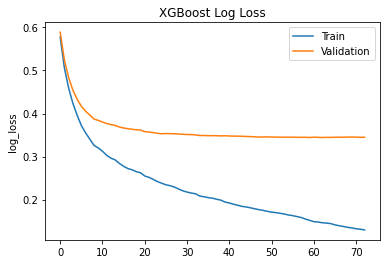

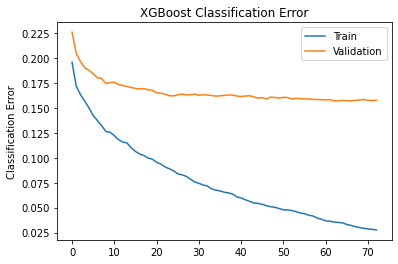

In [83]:
### ploting the model behavior on train and validation datasets over epochs
eval_set = [(x_train, y_train),(x_validation, y_validation)]
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
plt.ylabel('log_loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Validation')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

,feature,importance
194,topoElevationMean,0.043889
159,ERA5_temperature_2m_oct,0.038882
191,ERA5_temperature_2m_dec,0.024432
175,ERA5_temperature_2m_nov,0.021099
15,ERA5_temperature_2m_jan,0.017076
...,...,...
151,S2_B7_oct,0.002388
153,S2_B8A_oct,0.002317
154,S2_B9_oct,0.002301
122,S2_B9_aug,0.002109


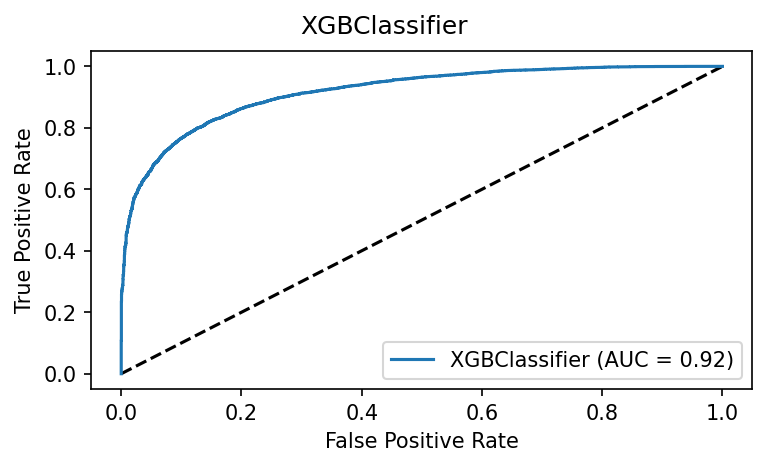

In [84]:
## ROC metric 
evaluate_model(x_train, y_train, x_validation, y_validation, model)

In [86]:

test_nolabels_prediction = predictOnSet(model, test_nolabels)
test_nolabels_prediction = np.int8(test_nolabels_prediction)
savePrediction(test_nolabels_prediction, 'XGBCl_bestRF_Standard.csv')
print(test_nolabels_prediction[0:50])

[0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0
 1 1 0 1 1 1 1 1 0 1 1 1 1]


In [ ]:
## Calculating F1 metrics for all produced models
modelNameList =  list{}

for model in modelNameList:
    model = pd.(model, index_col = None)
    model.fit(x_train, y_train) 
    y_hat = model.predict(x_validation)
    f1 = f1_score(model, x_validation,y_validation, average ='binary',zero_division = 0)
    roc = roc_auc_score(y_validation, y_hat)
    print("quality of prediction of " + model + ", f1_score:", f1, ", ROC: ", roc,"\n",)
    


In [87]:
testNoLabelFIrst = pd.read_csv("first_rfSearch_noLabelPrediction.csv", index_col = None)
xxx = testNoLabelFIrst['LABELS']
yyy = pd.read_csv('XGBCl_bestRF_Standard.csv',index_col = None)
yyy = yyy['LABELS'] 
accuracy = accuracy_score(xxx, yyy)
print("Accuracy xgboost: %.2f%%" % (accuracy))

Accuracy xgboost: 0.67%
